In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Tue Apr 13 06:24:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -q -U watermark

In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,torchvision

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 5.5.0

numpy      : 1.19.5
pandas     : 1.1.5
torch      : 1.8.1+cu101
torchvision: 0.9.1+cu101



In [ ]:
import torch, torchvision

from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import shutil
from collections import defaultdict

from torch import nn, optim

import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
train_folders = sorted(glob('/content/drive/MyDrive/70:30_Datasets/70:30_train_test/*'))
len(train_folders)

5

In [ ]:
def load_image(img_path, resize=True):
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

  if resize:
    img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)

  return img

def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')

def show_sign_grid(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

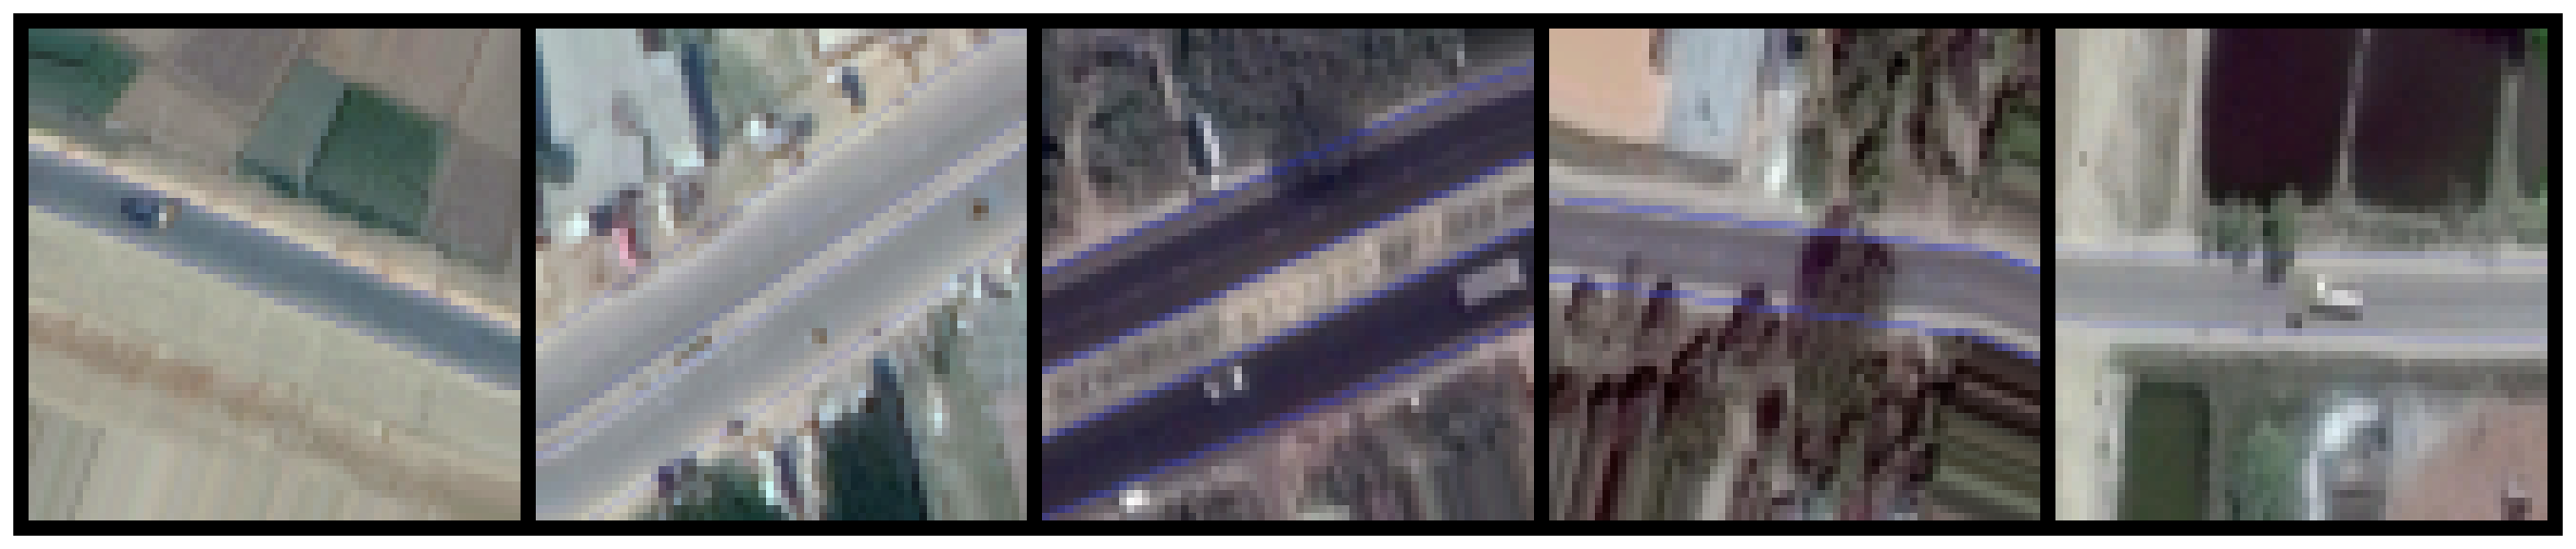

In [ ]:
sample_images = [np.random.choice(glob(f'{tf}/*png')) for tf in train_folders]
show_sign_grid(sample_images)

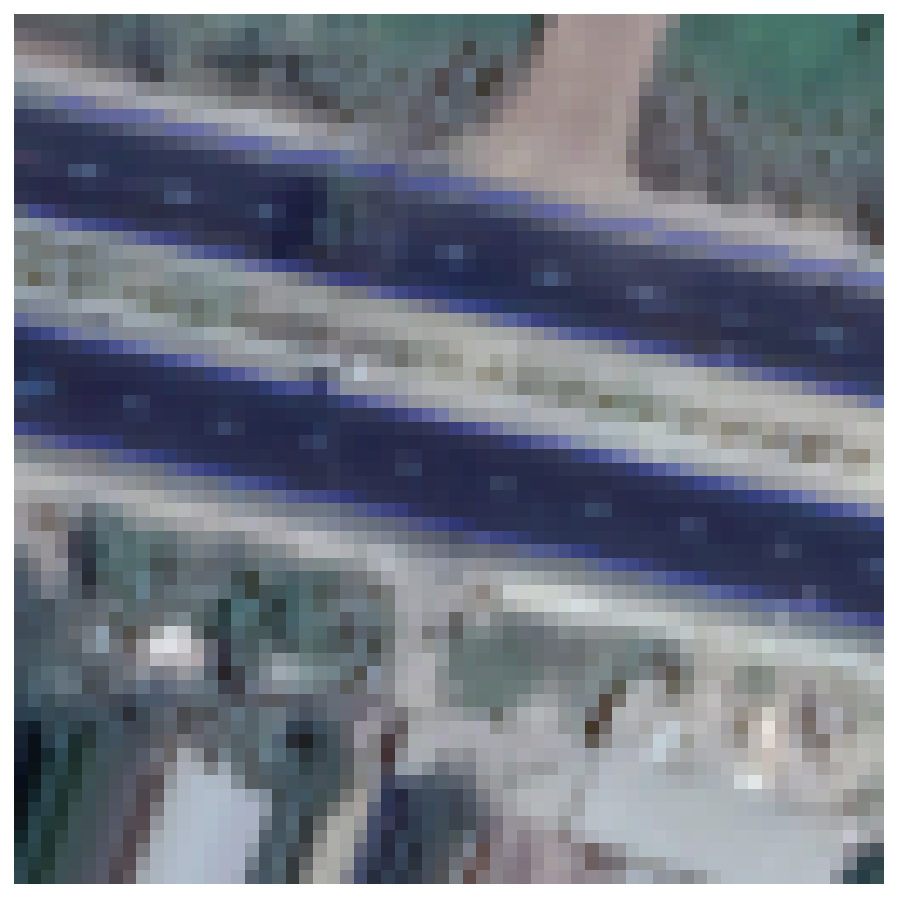

In [ ]:
img_path = glob(f'{train_folders[2]}/*png')[20]

show_image(img_path)

In [ ]:
class_names = ['bad', 'fair', 'good', 'poor','vbad']

class_indices = [0, 1, 2, 3, 4]

In [ ]:
!rm -rf data

DATA_DIR = Path('data')

DATASETS = ['train', 'val']

for ds in DATASETS:
  for cls in class_names:
    (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

In [ ]:
for i, cls_index in enumerate(class_indices):
  image_paths = np.array(glob(f'{train_folders[cls_index]}/*.png'))
  class_name = class_names[i]
  print(f'{class_name}: {len(image_paths)}')
  np.random.shuffle(image_paths)

  ds_split = np.split(
    image_paths, 
    indices_or_sections=[int(.8*len(image_paths))]
  )

  dataset_data = zip(DATASETS, ds_split)

  for ds, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')

bad: 4228
fair: 4779
good: 4812
poor: 4368
vbad: 3728


In [ ]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'train': T.Compose([
  T.Resize(64),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'val': T.Compose([
  T.Resize(size=80),
  T.CenterCrop(size=64),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

In [ ]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'train': T.Compose([
  T.Resize(224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'val': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

In [ ]:
image_datasets = {
  d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

data_loaders = {
  d: DataLoader(image_datasets[d], batch_size=16, shuffle=True, num_workers=2) 
  for d in DATASETS
}

In [ ]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['train'].classes

dataset_sizes

{'train': 17530, 'val': 4385}

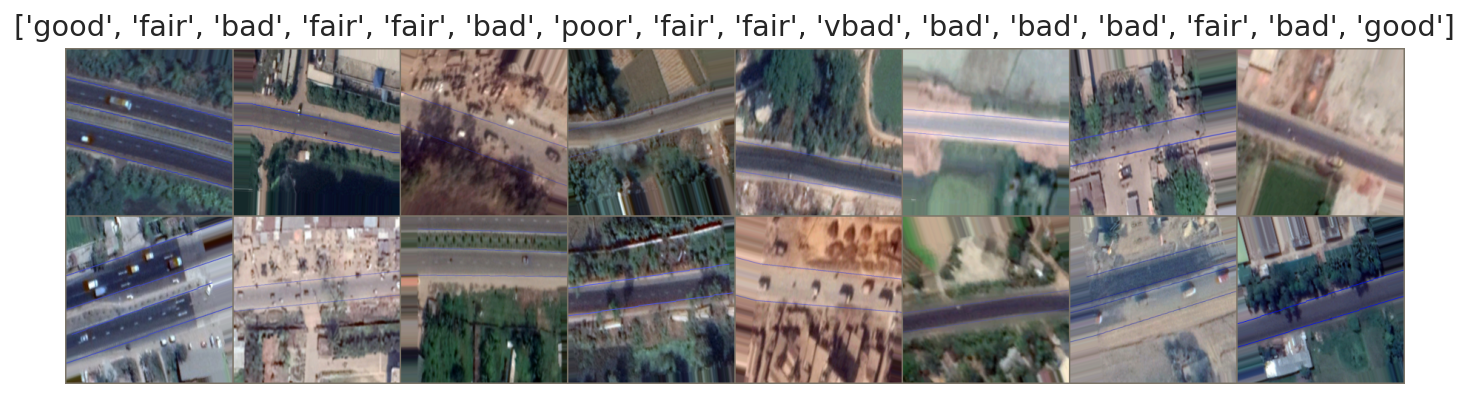

In [ ]:
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([mean_nums])
  std = np.array([std_nums])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.axis('off')

inputs, classes = next(iter(data_loaders['train']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def create_model():
  model = models.vgg16(pretrained=True)
  return model.to(device)

In [ ]:
base_model = create_model()

In [ ]:
base_model.classifier[-1]

Linear(in_features=4096, out_features=1000, bias=True)

In [ ]:
IN_FEATURES = base_model.classifier[-1].in_features 

final_fc = nn.Linear(IN_FEATURES,len(class_names) )

In [ ]:
base_model.classifier[-1] = final_fc

In [ ]:
print(base_model.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=5, bias=True)
)


In [ ]:
base_model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for inputs, labels in data_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  scheduler.step()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)

      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def train_model(model, data_loaders, dataset_sizes, device, n_epochs=10):
  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
  scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
  loss_fn = nn.CrossEntropyLoss().to(device)

  history = defaultdict(list)
  best_accuracy = 0

  for epoch in range(n_epochs):

    print(f'Epoch {epoch + 1}/{n_epochs}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
      model,
      data_loaders['train'],    
      loss_fn, 
      optimizer, 
      device, 
      scheduler, 
      dataset_sizes['train']
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
      model,
      data_loaders['val'],
      loss_fn,
      device,
      dataset_sizes['val']
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
      torch.save(model.state_dict(), 'best_model_state.bin')
      best_accuracy = val_acc

  print(f'Best val accuracy: {best_accuracy}')
  
  model.load_state_dict(torch.load('best_model_state.bin'))

  return model, history

In [ ]:
%%time
#64*64
base_model, history = train_model(base_model, data_loaders, dataset_sizes, device)

Epoch 1/10
----------
Train loss 0.9040069199799403 accuracy 0.6313747860810041
Val   loss 0.6883621882850474 accuracy 0.7352337514253136

Epoch 2/10
----------
Train loss 0.5523931159413535 accuracy 0.7858528237307474
Val   loss 0.7774056604782924 accuracy 0.7496009122006841

Epoch 3/10
----------
Train loss 0.378076958337486 accuracy 0.8552196235025671
Val   loss 0.45161920337514444 accuracy 0.825085518814139

Epoch 4/10
----------
Train loss 0.26401182785494265 accuracy 0.9003993154592128
Val   loss 0.5750565141938966 accuracy 0.8155074116305587

Epoch 5/10
----------
Train loss 0.17939387300870904 accuracy 0.9346833998859099
Val   loss 0.5125900822065094 accuracy 0.8230330672748004

Epoch 6/10
----------
Train loss 0.13428423772172482 accuracy 0.9514546491728466
Val   loss 0.5041048348668582 accuracy 0.850855188141391

Epoch 7/10
----------
Train loss 0.09199107532249466 accuracy 0.9692527096406162
Val   loss 0.5150047173977575 accuracy 0.8524515393386545

Epoch 8/10
----------
Tra

In [ ]:
%%time
#224*224
base_model, history = train_model(base_model, data_loaders, dataset_sizes, device)

Epoch 1/10
----------
Train loss 0.7680620545127096 accuracy 0.6822589845978323
Val   loss 0.5863151492855766 accuracy 0.7733181299885975

Epoch 2/10
----------
Train loss 0.45043995110725943 accuracy 0.8237307472903594
Val   loss 0.7541352092406967 accuracy 0.7717217787913341

Epoch 3/10
----------
Train loss 0.2974483224114634 accuracy 0.8847119224187108
Val   loss 0.5316850883149626 accuracy 0.8266818700114025

Epoch 4/10
----------
Train loss 0.19857263752262713 accuracy 0.9247575584711923
Val   loss 0.4765359568493709 accuracy 0.8542759407069556

Epoch 5/10
----------
Train loss 0.1304099617103611 accuracy 0.953280091272105
Val   loss 0.2743078173459931 accuracy 0.9037628278221208

Epoch 6/10
----------
Train loss 0.08751802937036621 accuracy 0.9698231602966344
Val   loss 0.20305485496805473 accuracy 0.9229190421892817

Epoch 7/10
----------
Train loss 0.07177214373810108 accuracy 0.9759840273816316
Val   loss 0.32041859888217666 accuracy 0.9026225769669327

Epoch 8/10
----------


In [ ]:
def plot_training_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

  ax1.plot(history['train_loss'], label='train loss')
  ax1.plot(history['val_loss'], label='validation loss')

  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax1.set_ylim([-0.05, 1.05])
  ax1.legend()
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Epoch')

  ax2.plot(history['train_acc'], label='train accuracy')
  ax2.plot(history['val_acc'], label='validation accuracy')

  ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax2.set_ylim([-0.05, 1.05])
  ax2.legend()

  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')

  fig.suptitle('Training history')

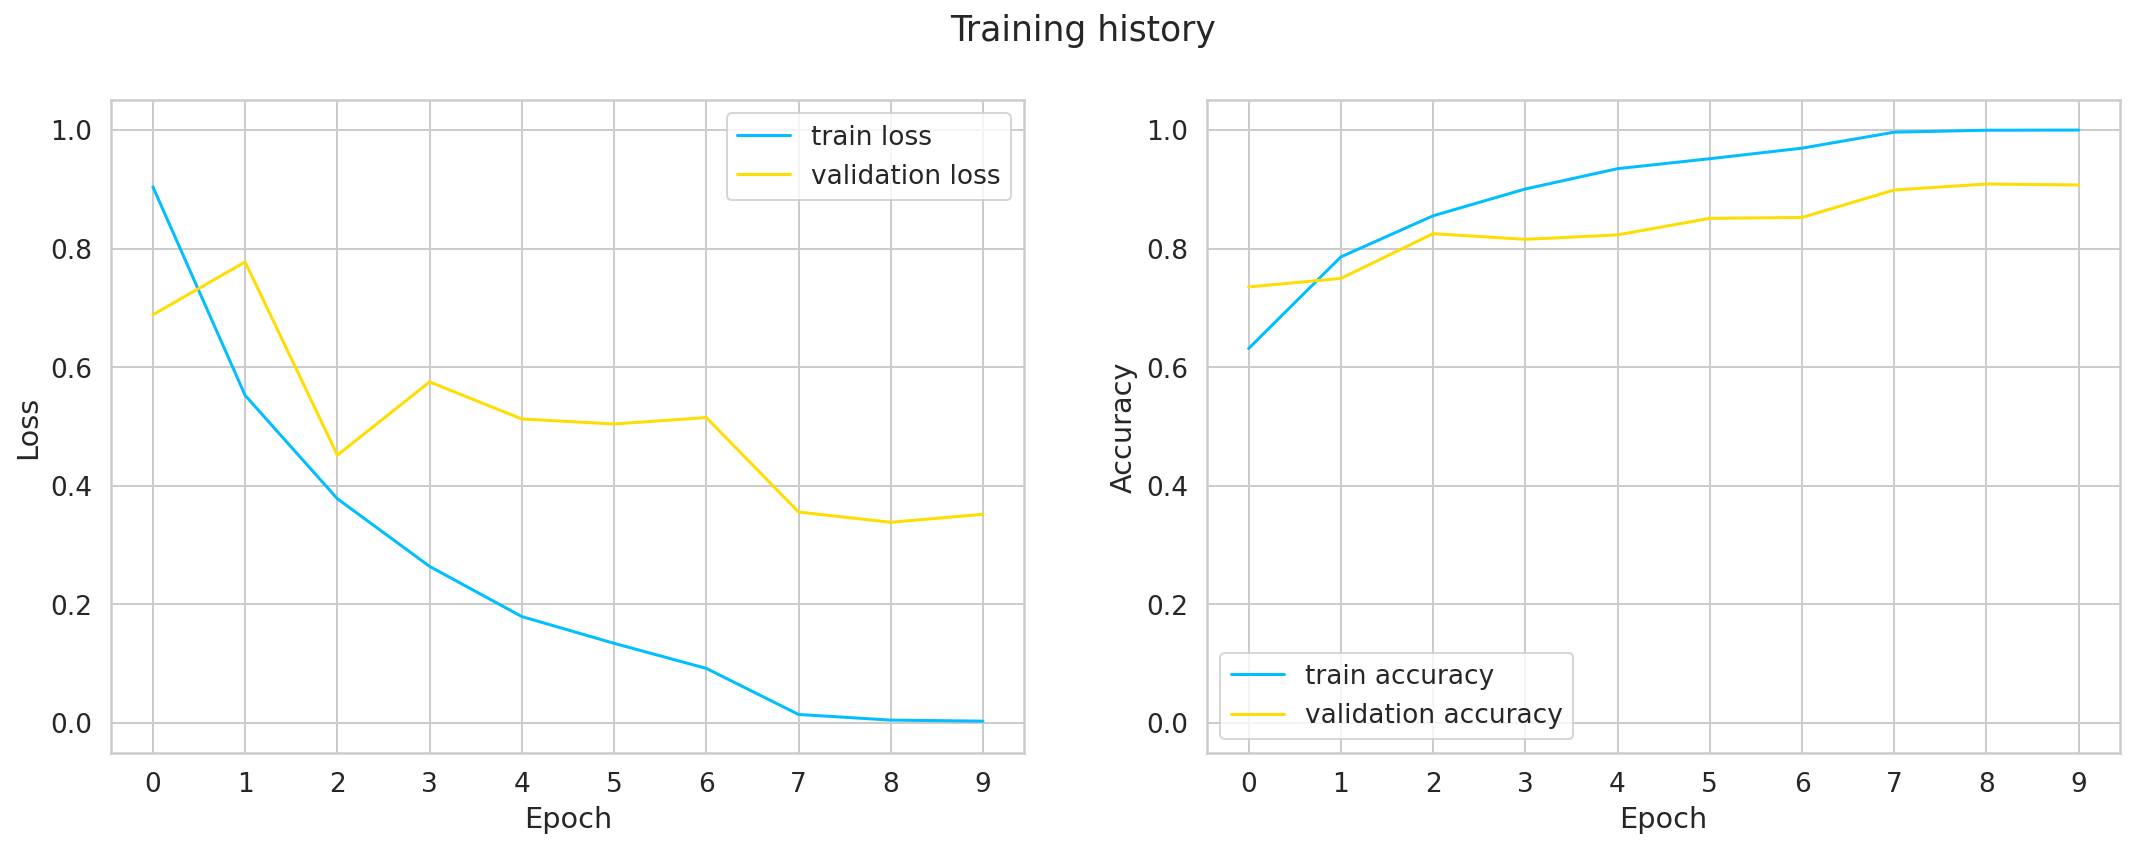

In [ ]:
#64*64
plot_training_history(history)

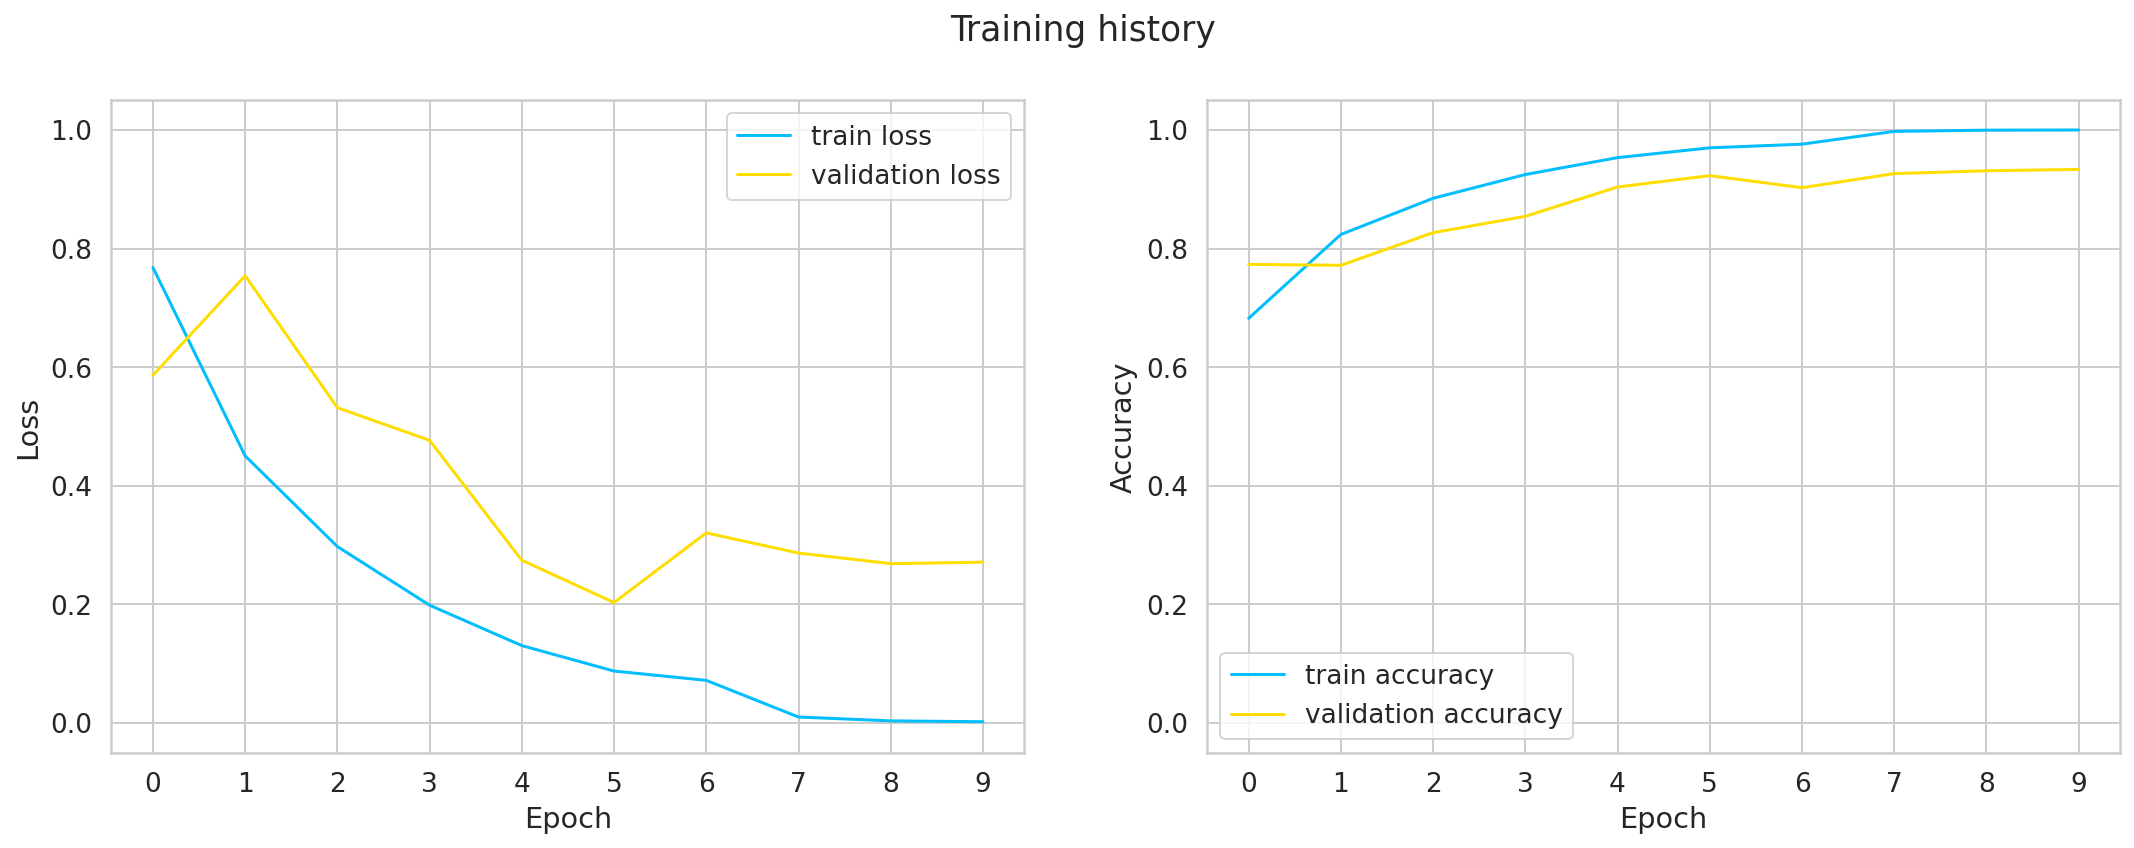

In [ ]:
#224*224
plot_training_history(history)

# **Test Data**(unseen)

In [ ]:
test_folders = sorted(glob('/content/drive/MyDrive/70:30_Datasets/test_set/*'))
len(test_folders)

5

In [ ]:
def load_image(img_path, resize=True):
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

  if resize:
    img = cv2.resize(img, (128, 128), interpolation = cv2.INTER_AREA)

  return img

def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')

def show_sign_grid(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

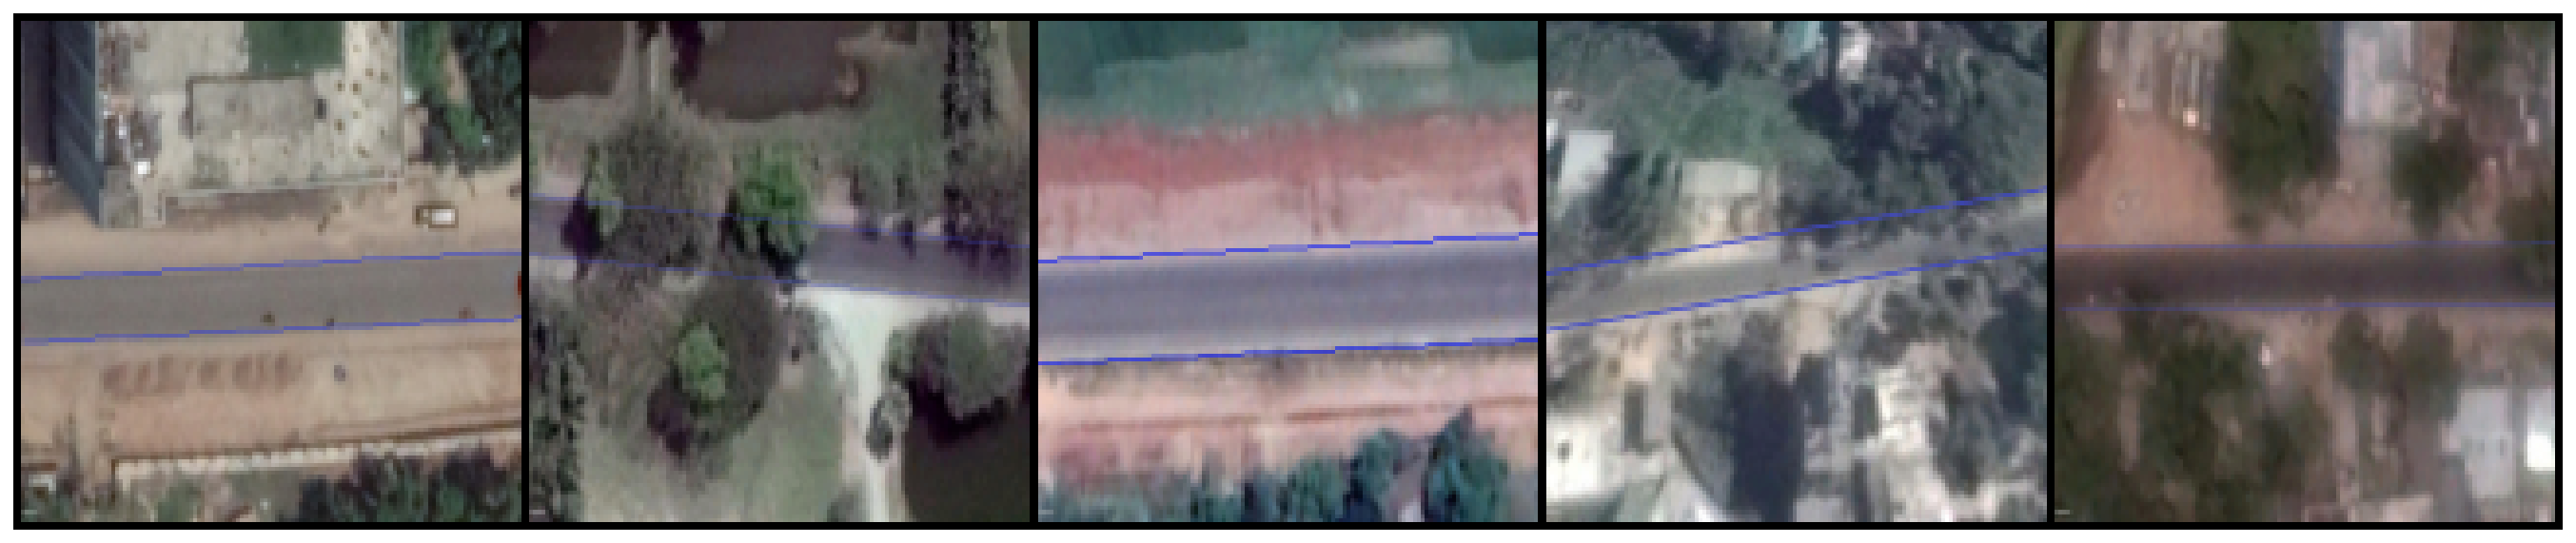

In [ ]:
sample_images = [np.random.choice(glob(f'{tf}/*png')) for tf in test_folders]
show_sign_grid(sample_images)

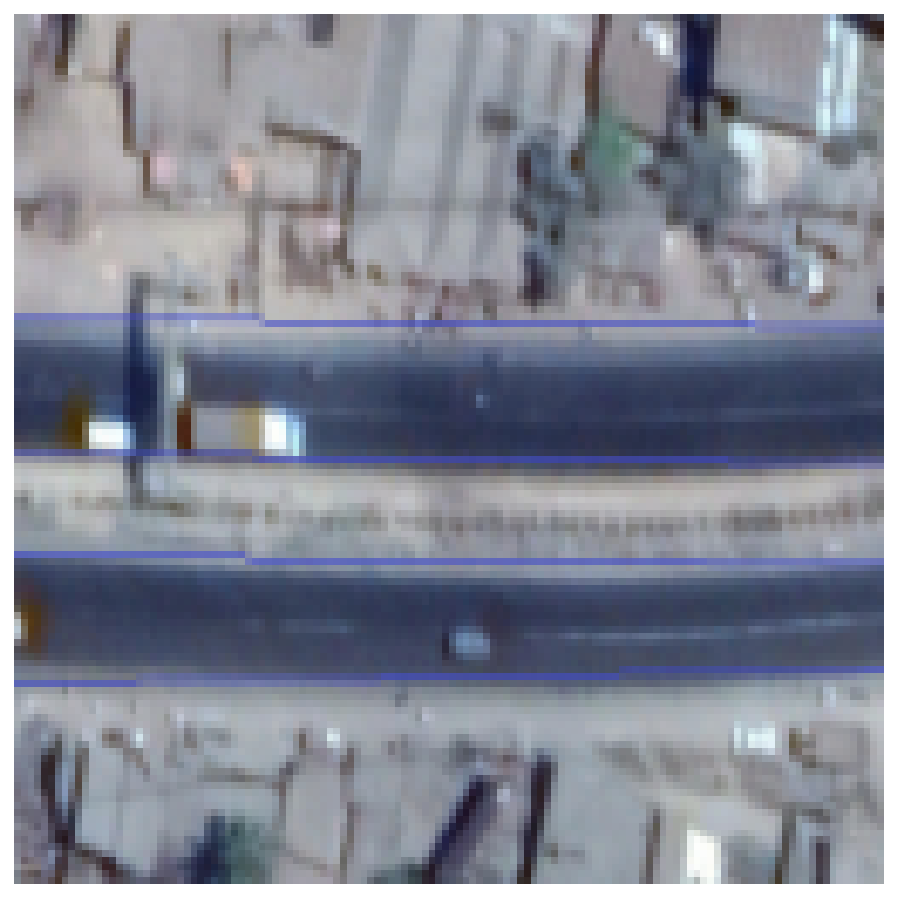

In [ ]:
img_path = glob(f'{test_folders[2]}/*png')[1]

show_image(img_path)

In [ ]:
class_names = ['bad', 'fair', 'good', 'poor','vbad']

class_indices = [0, 1, 2, 3, 4]

In [ ]:
!rm -rf data

DATA_DIR = Path('test_data')

DATASETS = ['test']

for ds in DATASETS:
  for cls in class_names:
    (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

In [ ]:
for i, cls_index in enumerate(class_indices):
  image_paths = np.array(glob(f'{test_folders[cls_index]}/*.png'))
  class_name = class_names[i]
  print(f'{class_name}: {len(image_paths)}')
  np.random.shuffle(image_paths)

  ds_split = np.split(
    image_paths, 
    indices_or_sections=[int(1.0*len(image_paths))]
  )

  dataset_data = zip(DATASETS, ds_split)

  for ds, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')

bad: 251
fair: 290
good: 295
poor: 263
vbad: 231


In [ ]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'test': T.Compose([
  T.Resize(size=80),
  T.CenterCrop(size=64),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

In [ ]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'test': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

In [ ]:
image_datasets = {
  d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

data_loaders = {
  d: DataLoader(image_datasets[d], batch_size=5, shuffle=True, num_workers=2) 
  for d in DATASETS
}

In [ ]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['test'].classes

dataset_sizes

{'test': 1330}

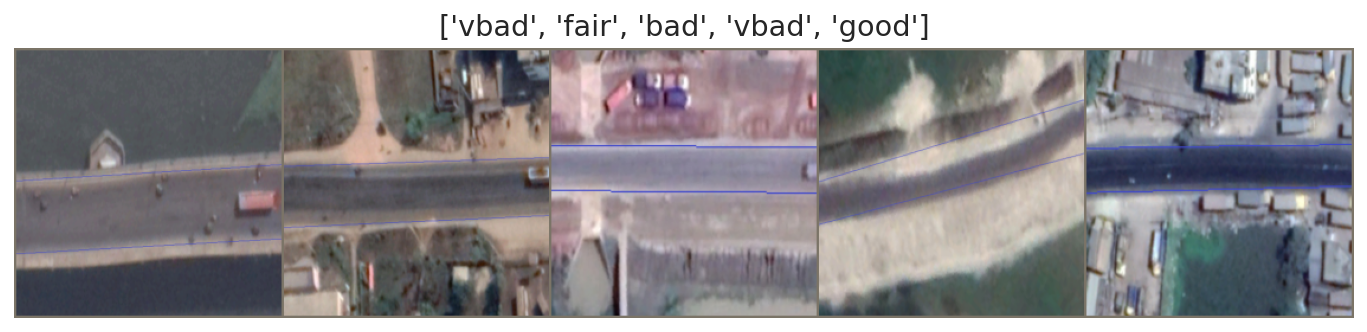

In [ ]:
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([mean_nums])
  std = np.array([std_nums])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.axis('off')

inputs, classes = next(iter(data_loaders['test']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def show_predictions(model, class_names, n_images=6):
  model = model.eval()
  images_handeled = 0
  plt.figure(figsize=(20,10))

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(data_loaders['test']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.shape[0]):
        images_handeled += 1
        ax = plt.subplot(2, n_images//2, images_handeled)
        ax.set_title(f'predicted: {class_names[preds[j]]}\n'  f'true: {class_names[labels[j]]}')
        imshow(inputs.cpu().data[j])
        ax.axis('off')

        if images_handeled == n_images:
          return

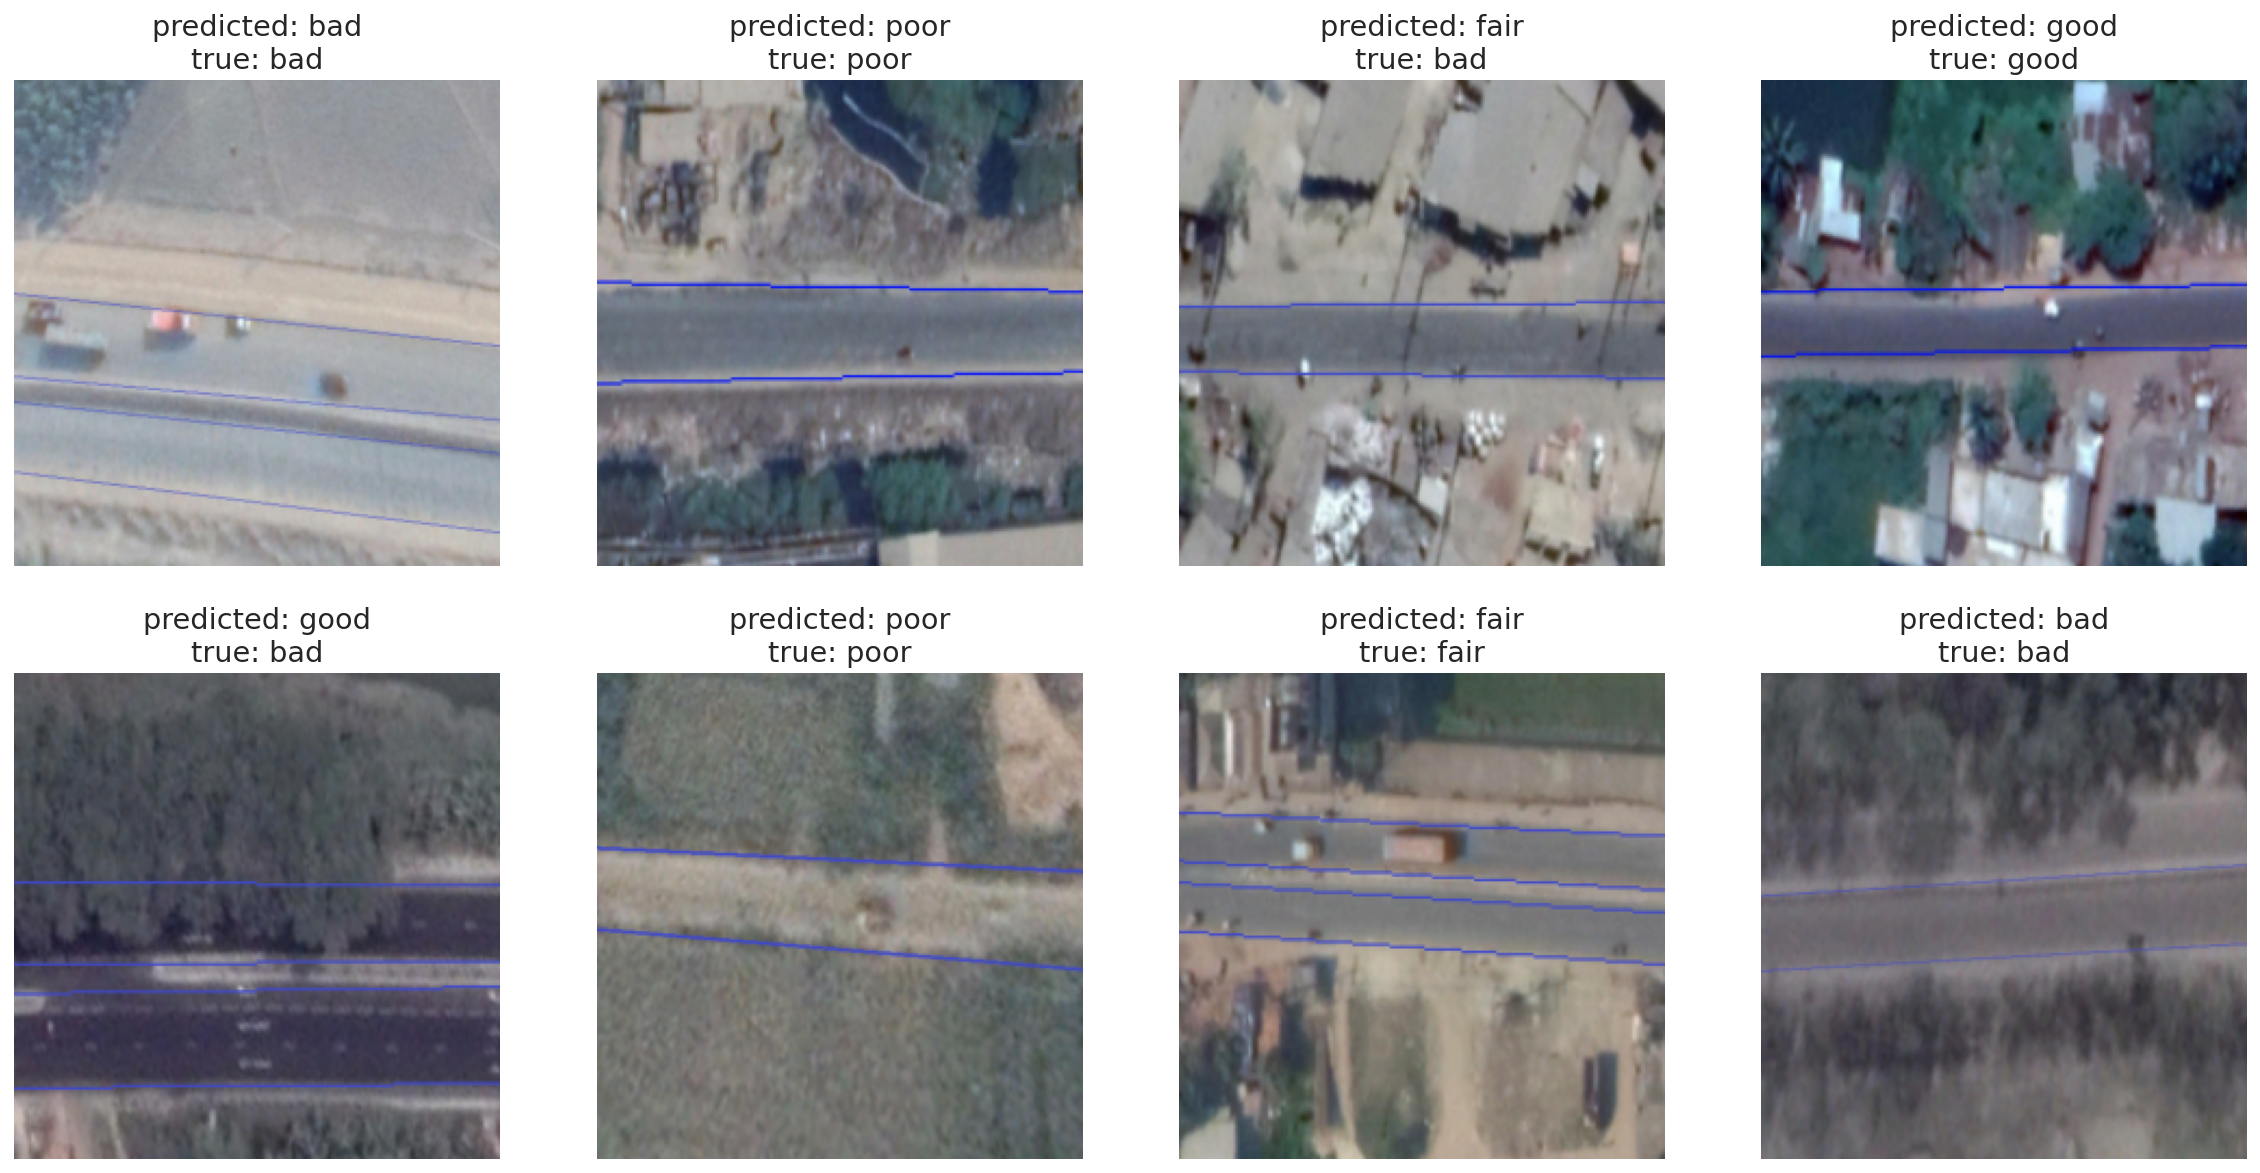

In [ ]:
show_predictions(base_model, class_names, n_images=8)

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  predictions = []
  real_values = []
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      predictions.extend(preds)
      real_values.extend(labels)
  predictions = torch.as_tensor(predictions).cpu()
  real_values = torch.as_tensor(real_values).cpu()
  return predictions, real_values

In [ ]:
y_pred, y_test = get_predictions(base_model, data_loaders['test'])

In [ ]:
#64*64
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

         bad       0.82      0.77      0.80       251
        fair       0.77      0.64      0.70       290
        good       0.73      0.81      0.77       295
        poor       0.85      0.86      0.86       263
        vbad       0.75      0.84      0.79       231

    accuracy                           0.78      1330
   macro avg       0.78      0.78      0.78      1330
weighted avg       0.78      0.78      0.78      1330



In [ ]:
#224*224
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

         bad       0.83      0.82      0.82       251
        fair       0.83      0.73      0.78       290
        good       0.78      0.86      0.82       295
        poor       0.91      0.85      0.88       263
        vbad       0.79      0.87      0.83       231

    accuracy                           0.82      1330
   macro avg       0.83      0.83      0.83      1330
weighted avg       0.83      0.82      0.82      1330



In [ ]:
def show_confusion_matrix(confusion_matrix, class_names):

  cm = confusion_matrix.copy()

  cell_counts = cm.flatten()

  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]

  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]

  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])

  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)

  hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Sign')
  plt.xlabel('Predicted Sign');

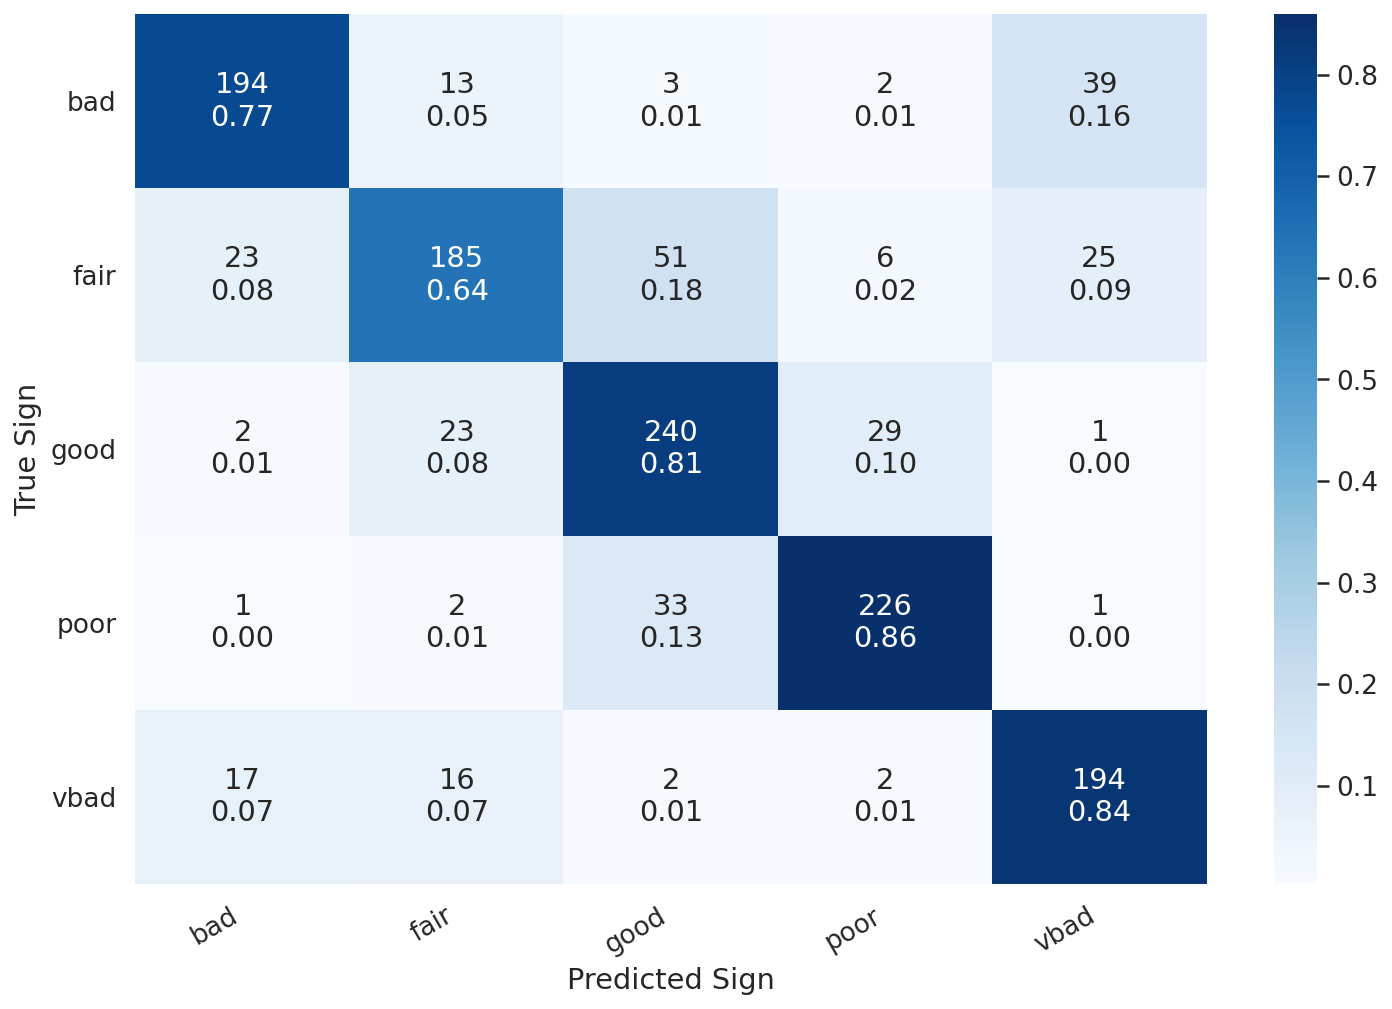

In [ ]:
#64*64
cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_names)

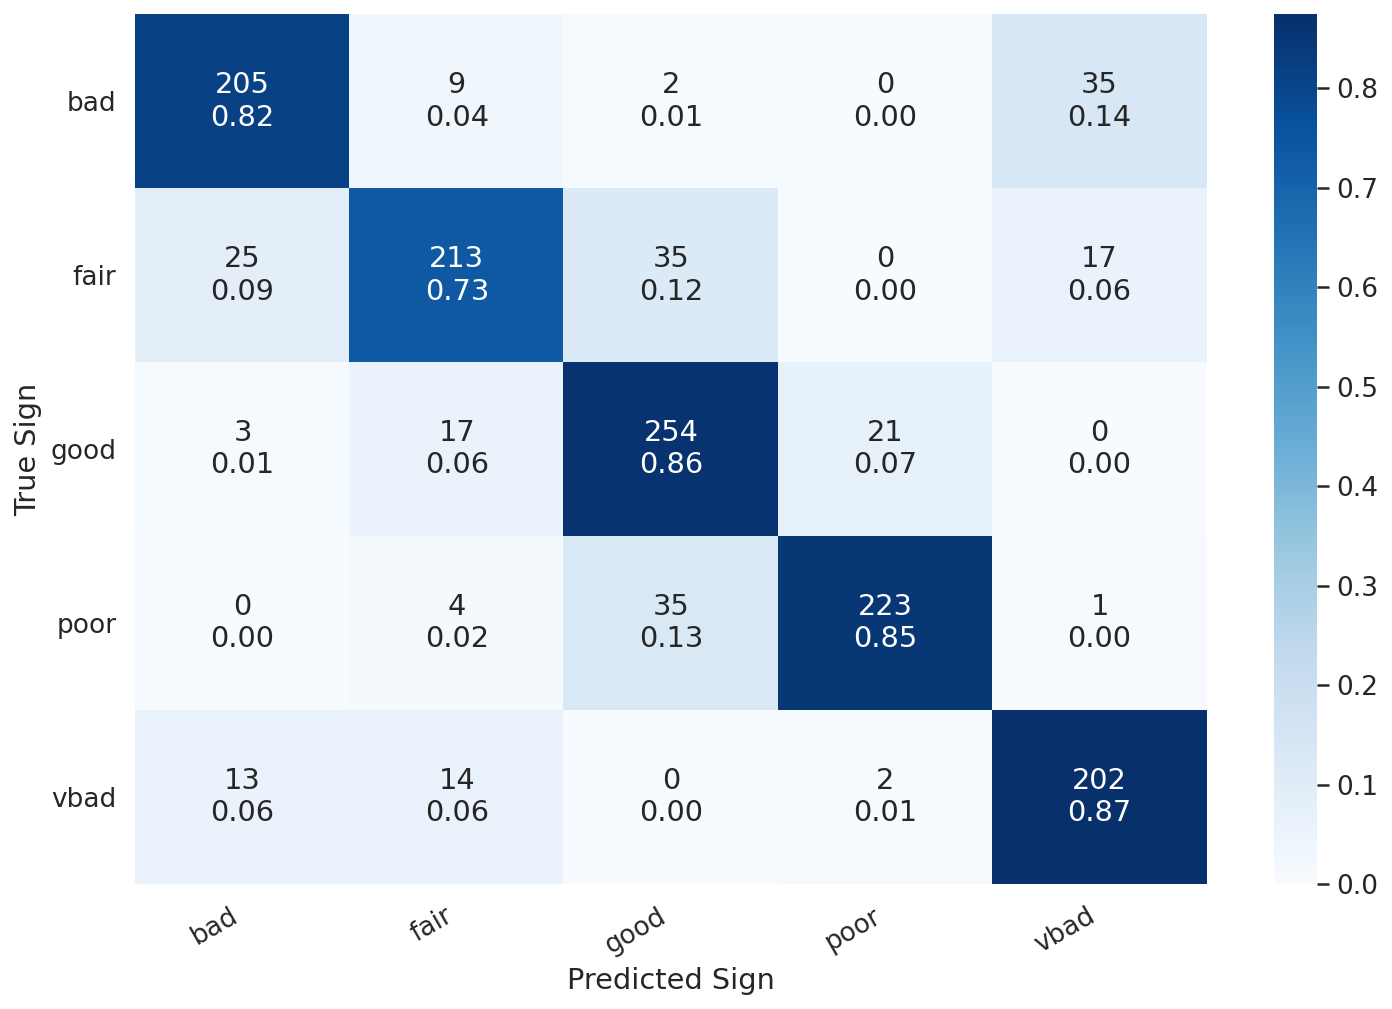

In [ ]:
#224*224
cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_names)

# **Hold out dataset(New Road for testing)**

In [ ]:
held_folders = sorted(glob('/content/drive/MyDrive/heldoutV2/*'))
len(held_folders)

5

In [ ]:
def load_image(img_path, resize=True):
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

  if resize:
    img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)

  return img

def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')

def show_sign_grid(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

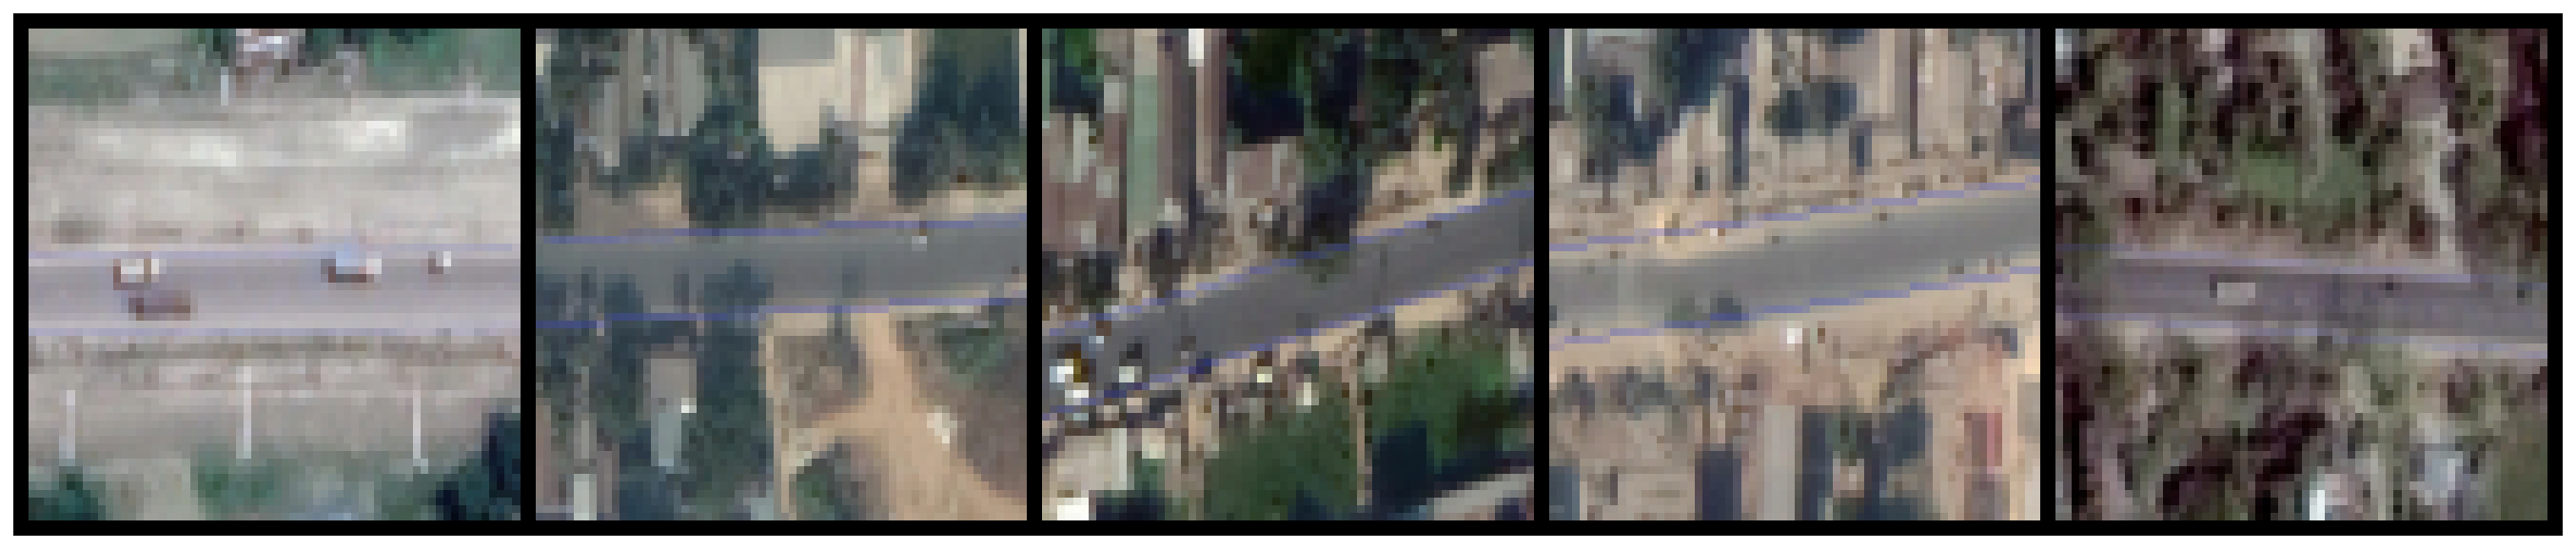

In [ ]:
sample_images = [np.random.choice(glob(f'{tf}/*png')) for tf in held_folders]
show_sign_grid(sample_images)

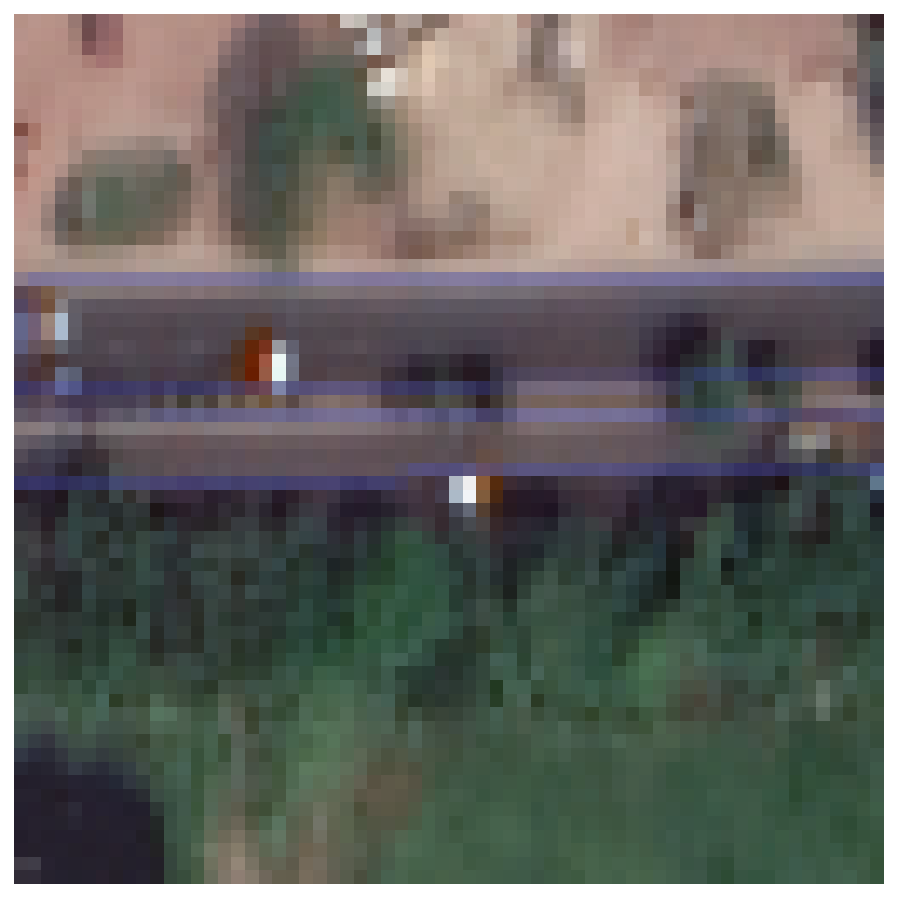

In [ ]:
img_path = glob(f'{held_folders[2]}/*png')[20]

show_image(img_path)

In [ ]:
class_names = ['bad', 'fair', 'good', 'poor','vbad']

class_indices = [0, 1, 2, 3, 4]

In [ ]:
!rm -rf data

DATA_DIR = Path('heldoutx_data')

DATASETS = ['heldout_test']

for ds in DATASETS:
  for cls in class_names:
    (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

In [ ]:
for i, cls_index in enumerate(class_indices):
  image_paths = np.array(glob(f'{held_folders[cls_index]}/*.png'))
  class_name = class_names[i]
  print(f'{class_name}: {len(image_paths)}')
  np.random.shuffle(image_paths)

  ds_split = np.split(
    image_paths, 
    indices_or_sections=[int(1.0*len(image_paths))]
  )

  dataset_data = zip(DATASETS, ds_split)

  for ds, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')

bad: 104
fair: 113
good: 115
poor: 91
vbad: 94


In [ ]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'heldout_test': T.Compose([
  T.Resize(size=80),
  T.CenterCrop(size=64),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

In [ ]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'heldout_test': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

In [ ]:
image_datasets = {
  d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

data_loaders = {
  d: DataLoader(image_datasets[d], batch_size=10, shuffle=True, num_workers=2) 
  for d in DATASETS
}

In [ ]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['heldout_test'].classes

dataset_sizes

{'heldout_test': 517}

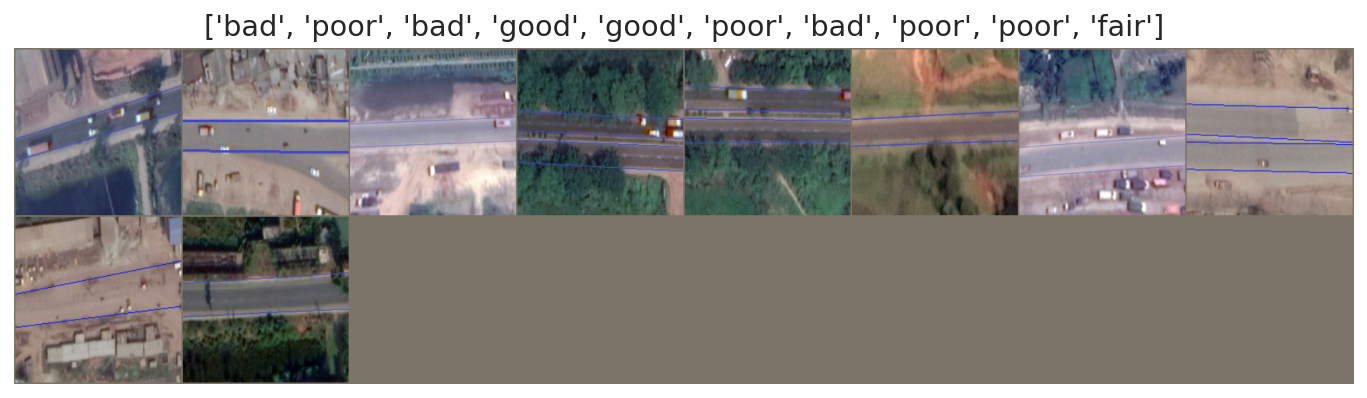

In [ ]:
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([mean_nums])
  std = np.array([std_nums])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.axis('off')

inputs, classes = next(iter(data_loaders['heldout_test']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  predictions = []
  real_values = []
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      predictions.extend(preds)
      real_values.extend(labels)
  predictions = torch.as_tensor(predictions).cpu()
  real_values = torch.as_tensor(real_values).cpu()
  return predictions, real_values

In [ ]:
y_pred, y_test = get_predictions(base_model, data_loaders['heldout_test'])

In [ ]:
#64*64
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

         bad       0.57      0.70      0.63       104
        fair       0.34      0.41      0.37       115
        good       0.41      0.30      0.35       113
        poor       0.70      0.52      0.59        91
        vbad       0.63      0.66      0.65        94

    accuracy                           0.51       517
   macro avg       0.53      0.52      0.52       517
weighted avg       0.52      0.51      0.51       517



In [ ]:
#224*224
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

         bad       0.53      0.73      0.62       104
        fair       0.36      0.56      0.43       113
        good       0.41      0.23      0.29       115
        poor       0.98      0.46      0.63        91
        vbad       0.69      0.67      0.68        94

    accuracy                           0.52       517
   macro avg       0.59      0.53      0.53       517
weighted avg       0.57      0.52      0.52       517



In [ ]:
def show_confusion_matrix(confusion_matrix, class_names):

  cm = confusion_matrix.copy()

  cell_counts = cm.flatten()

  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]

  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]

  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])

  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)

  hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Sign')
  plt.xlabel('Predicted Sign');

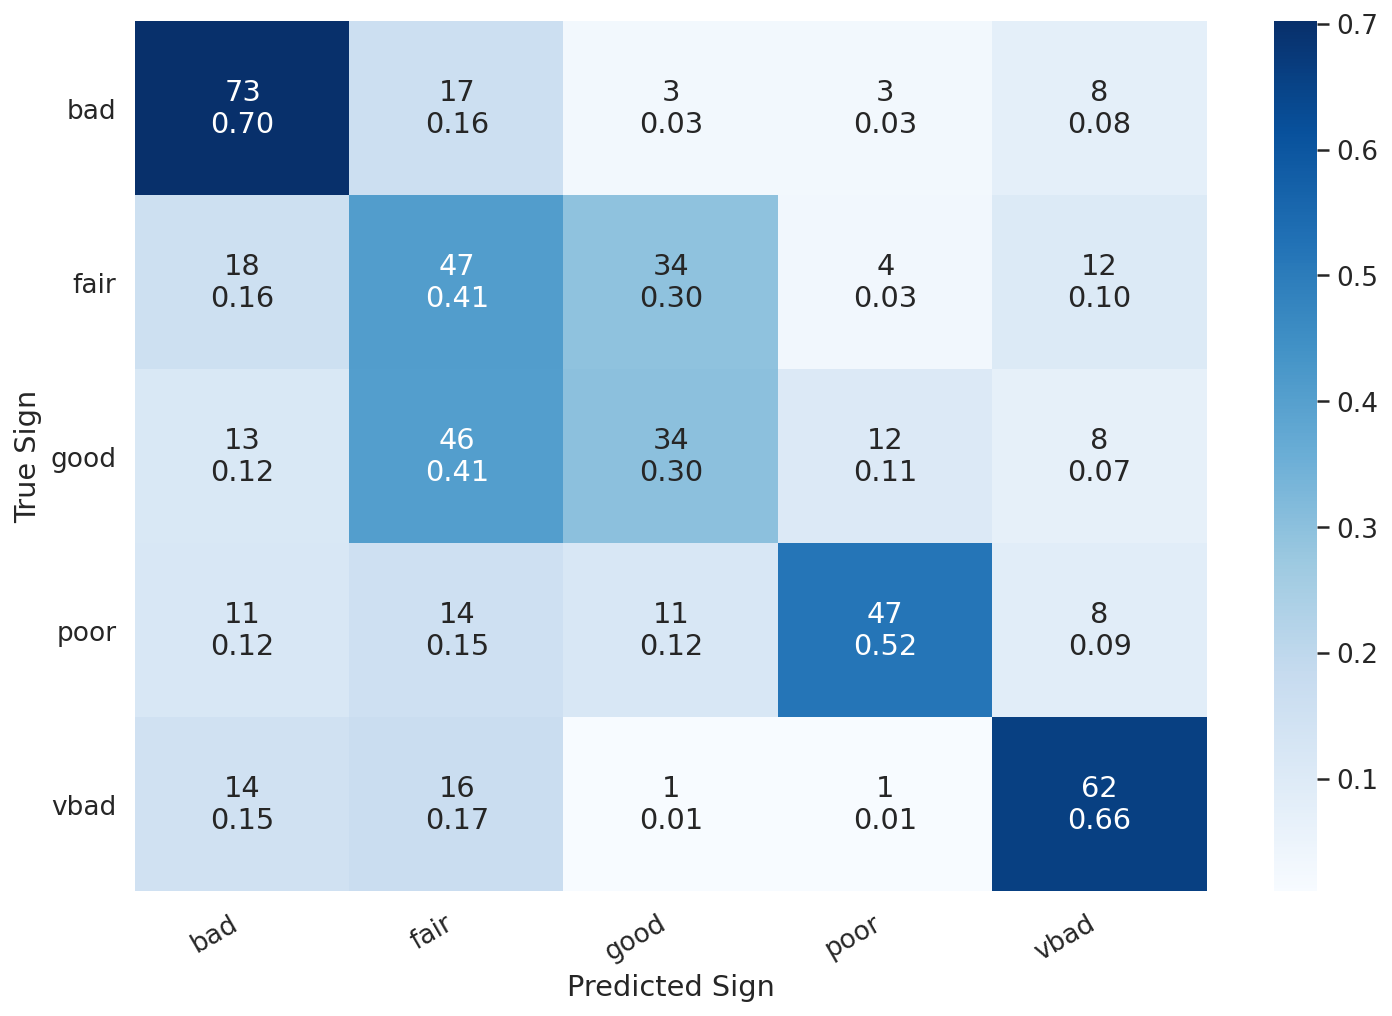

In [ ]:
#64*64
cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_names)

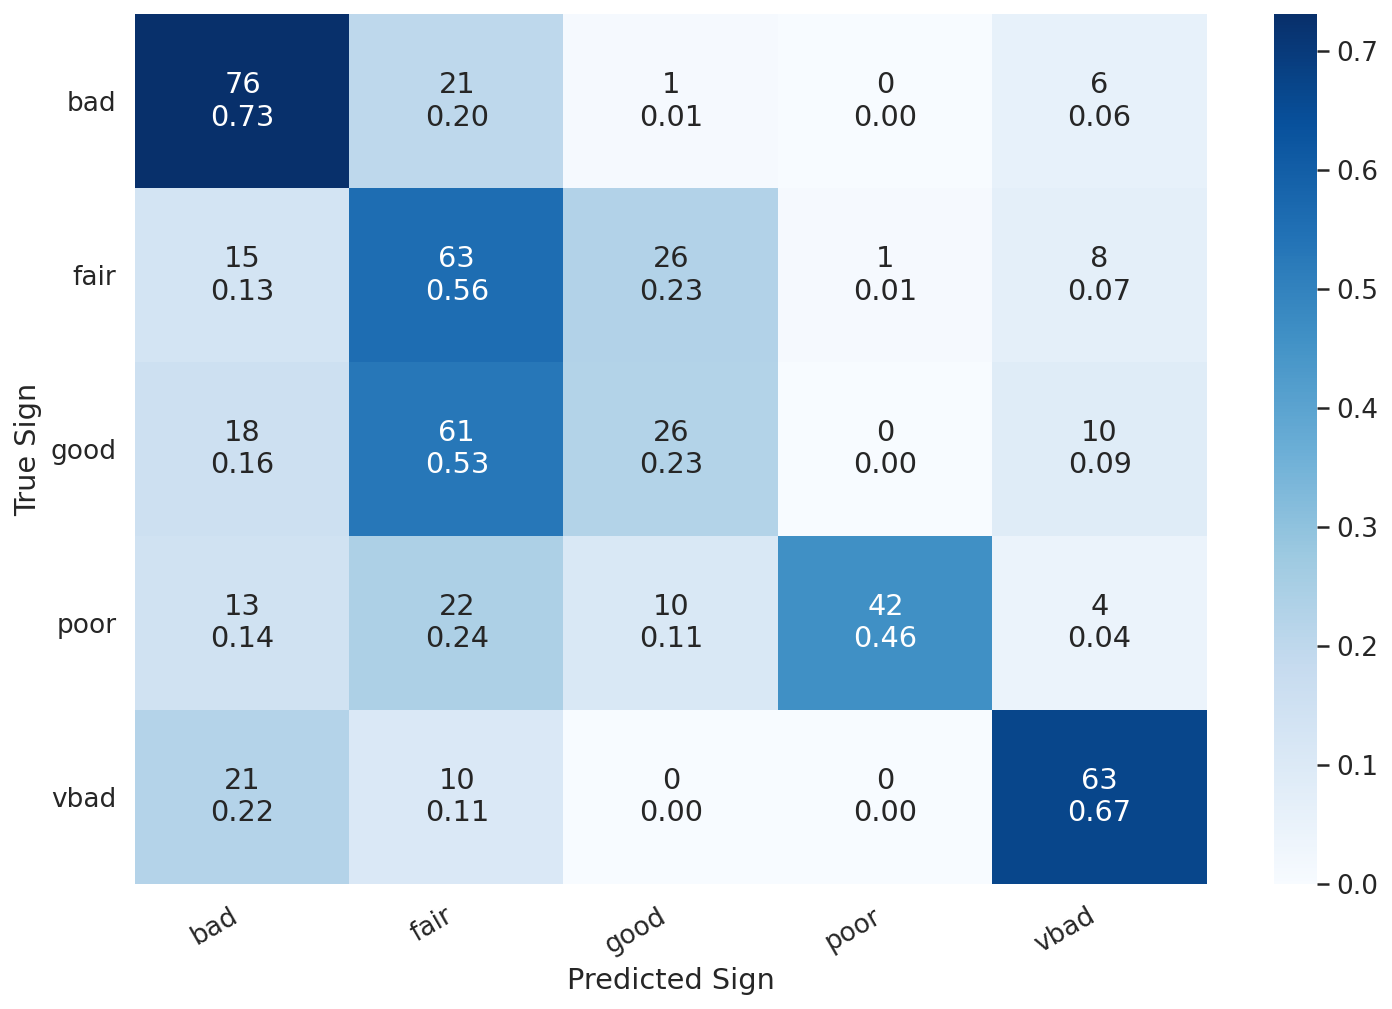

In [ ]:
#224*224
cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_names)

In [ ]:
root_path = '/content/drive/My Drive/'

In [ ]:
save_model = True

if save_model is True:
    # Saves only parameters
    # wights & biases
    torch.save(base_model.state_dict(), root_path + 'Vgg16703064.pkl') 

In [ ]:
load_model = True

if load_model is True:
    base_model.load_state_dict(torch.load(root_path + 'Vgg16703064.pkl'))
    print('Trained Model Loaded')

Trained Model Loaded


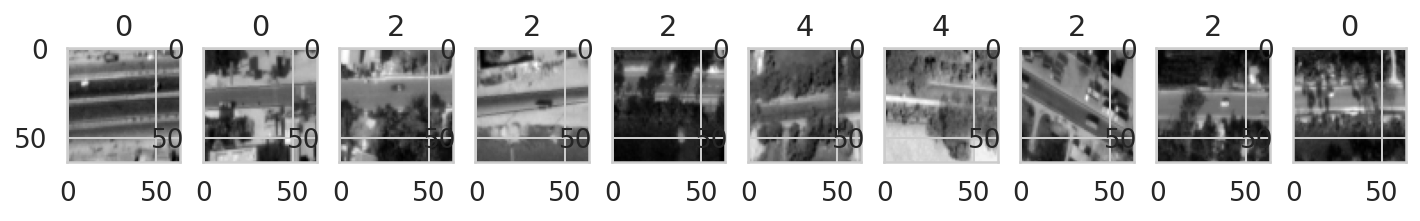

In [ ]:
for images, labels in data_loaders['heldout_test']:
    break
    
fig, ax = plt.subplots(1, 10)
for i in range(10):
    show_img = images[i][0].numpy().reshape(64, 64)
    ax[i].imshow(show_img,cmap='gray')
    ax[i].set_title(int(labels[i]))
    
plt.show()

In [ ]:
predictions = base_model.forward(images[:10].view(-1, 3,64,64).to(device))
predictions = torch.argmax(predictions, dim=1)
print('Predicted labels', predictions.cpu().numpy())

Predicted labels [0 1 1 2 2 4 4 1 0 0]


# 224*224

In [ ]:
root_path = '/content/drive/My Drive/'

In [ ]:
save_model = True

if save_model is True:
    # Saves only parameters
    # wights & biases
    torch.save(base_model.state_dict(), root_path + 'Vgg167030224.pkl') 

In [ ]:
load_model = True

if load_model is True:
    base_model.load_state_dict(torch.load(root_path + 'Vgg167030224.pkl'))
    print('Trained Model Loaded')

Trained Model Loaded


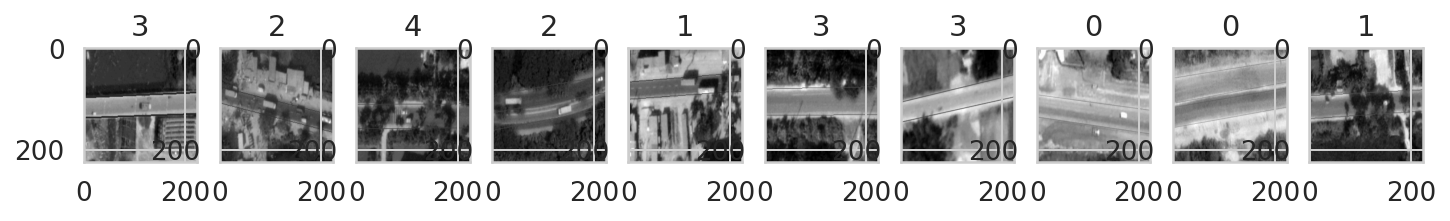

In [ ]:
for images, labels in data_loaders['heldout_test']:
    break
    
fig, ax = plt.subplots(1, 10)
for i in range(10):
    show_img = images[i][0].numpy().reshape(224, 224)
    ax[i].imshow(show_img,cmap='gray')
    ax[i].set_title(int(labels[i]))
    
plt.show()

In [ ]:
predictions = base_model.forward(images[:10].view(-1, 3,224,224).to(device))
predictions = torch.argmax(predictions, dim=1)
print('Predicted labels', predictions.cpu().numpy())

Predicted labels [3 1 0 1 0 1 3 0 0 1]
